# Show bout/motif rasters
- Assumes 
For every run in the session:
 - Load the recordings
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 - collect all the bout rasters and waveforms
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts
- sglx_pipe_sort_rasters:
    - sync of the streams lf, ap, nidq, wav to the ap_0 -> [stream]_sync_dict.pkl and all_syn_dict
    - get the bout_dict and sync all timestamps of toub to the ap_0 time
    - sort the spikes
    - load the spikes OPTIONAL STEP: MANUAL CURATION IN BETWEEN
    - annotate metadata on the spikes (e.g. putative nucleus of precedence)
    - save the spikes, clusters metadata pandas dataframes on the ['sort'] folder
    - save the syncrhonized bout_dict in the ['sort'] folder
    

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT3_PATH"] = '/home/finch/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'

In [2]:
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import syncutil as su
from ceciestunepipe.util import sglxsync as syn

h5py version > 2.10.0. Some extractors might not work properly. It is recommended to downgrade to version 2.10.0: 
>>> pip install h5py==2.10.0


In [3]:
logger.info('all modules loaded')

2021-11-09 14:57:04,242 root         INFO     all modules loaded


### Session parameters and raw files

In [4]:
reload(et)
bird = 's_b1253_21'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [5]:
reload(et)
sess_par = {'bird': 's_b1253_21',
           'sess': '2021-07-18',
           'probe': 'probe_0',
           'sort': 'sort_0'}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

In [6]:
raw_folder

'/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx'

In [7]:
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2021-11-09 14:57:04,959 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx', 'kwik': '/experiment/s_b1253_21/sglx/kwik/2021-07-18', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-07-18/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx', 'tmp': '/experiment/tmp/tmp', 'msort': '/experiment/tmp/s_b1253_21/sglx/msort/2021-07-18', 'ksort': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18/sort_0', 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/sort_0'}, 'files': {'par': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18/sort_0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/rig.json', 'kwd': '/experiment/s_b1253_21/

['0610_g0', '1423_g0', '1615_g0']

In [8]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest
sess_par['epoch'] = epoch
sess_par['sort'] = 'sort_0'

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [9]:
#exp_struct['folders']['raw'] = 'tuvieja'
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/0610_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/0610_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/0610_g0',
  'kwik': '/experiment/s_b1253_21/sglx/kwik/2021-07-18/0610_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-07-18/sglx/0610_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0',
  'tmp': '/experiment/tmp/tmp/0610_g0',
  'msort': '/experiment/tmp/s_b1253_21/sglx/msort/2021-07-18/0610_g0',
  'ksort': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18/0610_g0/sort_0',
  'sort': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/sort_0'},
 'files': {'par': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18/0610_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/rig.

In [10]:
sess_par

{'bird': 's_b1253_21',
 'sess': '2021-07-18',
 'probe': 'probe_0',
 'sort': 'sort_0',
 'epoch': '0610_g0'}

### Load the sync motif data

In [11]:
bout_dict_path = os.path.join(exp_struct['folders']['sort'], 'bout_dict_ap0.pkl')
logger.info('Loading manually curated bout metadata from {}'.format(bout_dict_path))
with open(bout_dict_path, 'rb') as handle:
    bout_dict = pickle.load(handle)

2021-11-09 14:57:07,602 root         INFO     Loading manually curated bout metadata from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/sort_0/bout_dict_ap0.pkl


#### relevant keys in the bout_dict
s_f: int, sample rate of the wav file used to search for the bouts.

s_f_ap_0: float, sample rate of the ap_0 channel to which the times were syncronized.

start_sample_wav: np.array(n_bout, dtype=int), start sample of each bout in the wav file.

start_sample_ap_0: np.array(n_bout, dtype=int), start sample of each bout in the ap_0 band of the sglx file.

len_ms: int, duration of the bout in ms (taken from the wav file).

In [12]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0'])

### read the microphone stream file that was used to detect the bouts
- wav file located in the derived_data folder: will be used to get the waveform of the bouts together with the spikes

In [13]:
from ceciestunepipe.util import wavutil as wu

In [14]:
wav_mic_path = exp_struct['files']['wav_mic']
logger.info('loading the microphone wav file ' + exp_struct['files']['wav_mic'])
s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'])

2021-11-09 14:57:10,435 root         INFO     loading the microphone wav file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/wav_mic.wav


In [16]:
wu.read_wav_chan??

Signature: wu.read_wav_chan(wav_path: str, chan_id: int = 0) -> tuple
Docstring: <no docstring>
Source:   
def read_wav_chan(wav_path: str, chan_id: int=0) -> tuple:
    s_f, x = wavfile.read(wav_path, mmap=True)
    if x.ndim==1:
        if chan_id > 0:
            raise ValueError('Wave file has only one channel, asking for channel {}'.format(chan_id))
        x = x.reshape(-1, 1)
    
    return s_f, x[:, chan_id]
File:      ~/repos/ceciestunepipe/ceciestunepipe/util/wavutil.py
Type:      function


### get the the sorting

In [27]:
logger.info('Will load cluster, spike dataframes from ' + exp_struct['folders']['sort'])

2021-11-09 12:17:06,850 root         INFO     Will load cluster, spike dataframes from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/sort_0


In [28]:
clu_df_path = os.path.join(exp_struct['folders']['sort'], 'clu_df.pkl')
clu_df = pd.read_pickle(clu_df_path)

spk_df_path = os.path.join(exp_struct['folders']['sort'], 'spk_df.pkl')
spk_df = pd.read_pickle(spk_df_path)


In [63]:
spk_df.head(1)

,times,clusters,nucelus,main_chan,kslabel
0,102,119,ra,50,good


In [29]:
clu_df.head(1)

,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
1,1,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 0, 2, 3, 5, 6, 4, 13, 9, 7, 10, 11, 8, 15,...",1,"[0, 1, 2, 3, 4, 5, 6]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


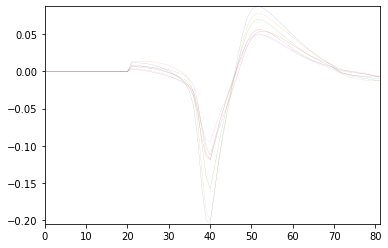

In [71]:
plt.plot(clu_df.loc[50, 'main_wav_7']);

#### example of filtering by nucelus, sua/mua

In [30]:
### count RA clusters
clu_df_ra = clu_df[clu_df['nucleus']=='ra']

# count them
np.unique(clu_df_ra['cluster_id']).size

384

In [73]:
np.unique(clu_df['KSLabel'])

array(['good', 'mua'], dtype=object)

In [72]:
### count RA SUA clusters
clu_df_ra_sua = clu_df[(clu_df['nucleus']=='ra') & (clu_df['KSLabel']=='good') ]

#count them
np.unique(clu_df_ra_sua['cluster_id']).size

62

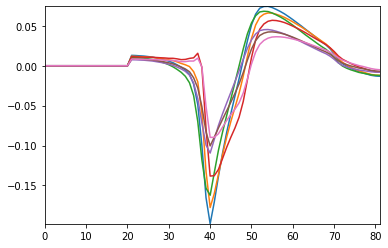

In [33]:
## plot an example waveform
plt.plot(clu_df.loc[40, 'main_wav_7']);

### collect bout rasters
- pick a list of clusters (e.g. filtered by nucleus='ra'; KSlabel='good'/'mua'
- pick a window around each bout
- collect the waveform for the bout
- collect the spikes for those clusters



In [35]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0'])

In [74]:
def get_window_spikes(spk_df, clu_list, start_sample, end_sample):
    onset = start_sample
    offset = end_sample
    
    spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
    
    spk_arr = np.zeros((clu_list.size, offset - onset))

    for i, clu_id in enumerate(clu_list):
        clu_spk_t = spk_t.loc[spk_t['clusters']==clu_id, 'times'].values
        spk_arr[i, clu_spk_t - onset] = 1
    return spk_arr

def collect_bout(bout_dict, bout_idx, t_pre, t_post, spk_df, clu_list, mic_stream):
    s_f_ap = bout_dict['s_f_ap_0']
    s_f_wav = bout_dict['s_f']
    
    ## add the length of the bout (in seconds) to the end of the segment
    t_post += int(bout_dict['len_ms'][bout_idx] * 0.001)
       
    start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(s_f_ap* t_pre)
    end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(s_f_ap * t_post)

    start_wav = bout_dict['start_sample_wav'][bout_idx] + int(s_f_wav * t_pre)
    end_wav = bout_dict['start_sample_wav'][bout_idx] + int(s_f_wav * t_post)


    # get the streams/spike array
    spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
    mic_arr = mic_stream.flatten()[start_wav: end_wav]
    
    return spk_arr, mic_arr

In [76]:
# lists of clusters: good, mua, all together
clu_list_ra_good = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['ra', 'hvc'])), 
                                'cluster_id'])

clu_list_ra_mua = np.unique(clu_df.loc[(clu_df['KSLabel']=='mua') & (clu_df['nucleus'].isin(['ra'])), 
                                'cluster_id'])

clu_list_ra_all = np.unique(clu_df.loc[(clu_df['nucleus'].isin(['ra'])), 
                                'cluster_id'])
#clu_list = np.unique(clu_df['cluster_id'])

# time previous to detected onset/offset of the bout to collect (in seconds)
t_pre = - 5
t_post = 5

# get the cluster raster array for just the first bout
bout_idx = 0
clu_list = clu_list_ra_good
spk_arr, mic_arr = collect_bout(bout_dict, bout_idx, t_pre, t_post, spk_df, clu_list, mic_stream)

<ipython-input-74-cb514117b64c>:5: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


### Visualize a bout together with the neural traces

In [77]:
plt.rcParams['lines.linewidth'] = 0.1
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu

In [78]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

In [79]:
def coarse(x: np.ndarray, n_coarse: int):
    # coarse x along last dimension in bins of n_coarse size
    x_shape = x.shape
    last_dim = x.shape[-1]
    
    max_n = last_dim//n_coarse * n_coarse # chop it to the max integer coarse
    exploded_x = x[..., :max_n].reshape(*x_shape[:-1], -1, n_coarse)
    coarse_x = np.nanmean(exploded_x, axis=-1)
    return coarse_x

def plot_as_raster(x, ax=None, t_0=None):
    # plot an array of n_instances, n_timestamps as a raster
    
    #x is [n_events, n_timestamps] array, with 0 where no spikes, 1 where spike
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='.', facecolor='k', s=1, rasterized=True)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax

### one example of bout onset

In [80]:
clu_list.size

62

<ipython-input-81-853548b3f06e>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')


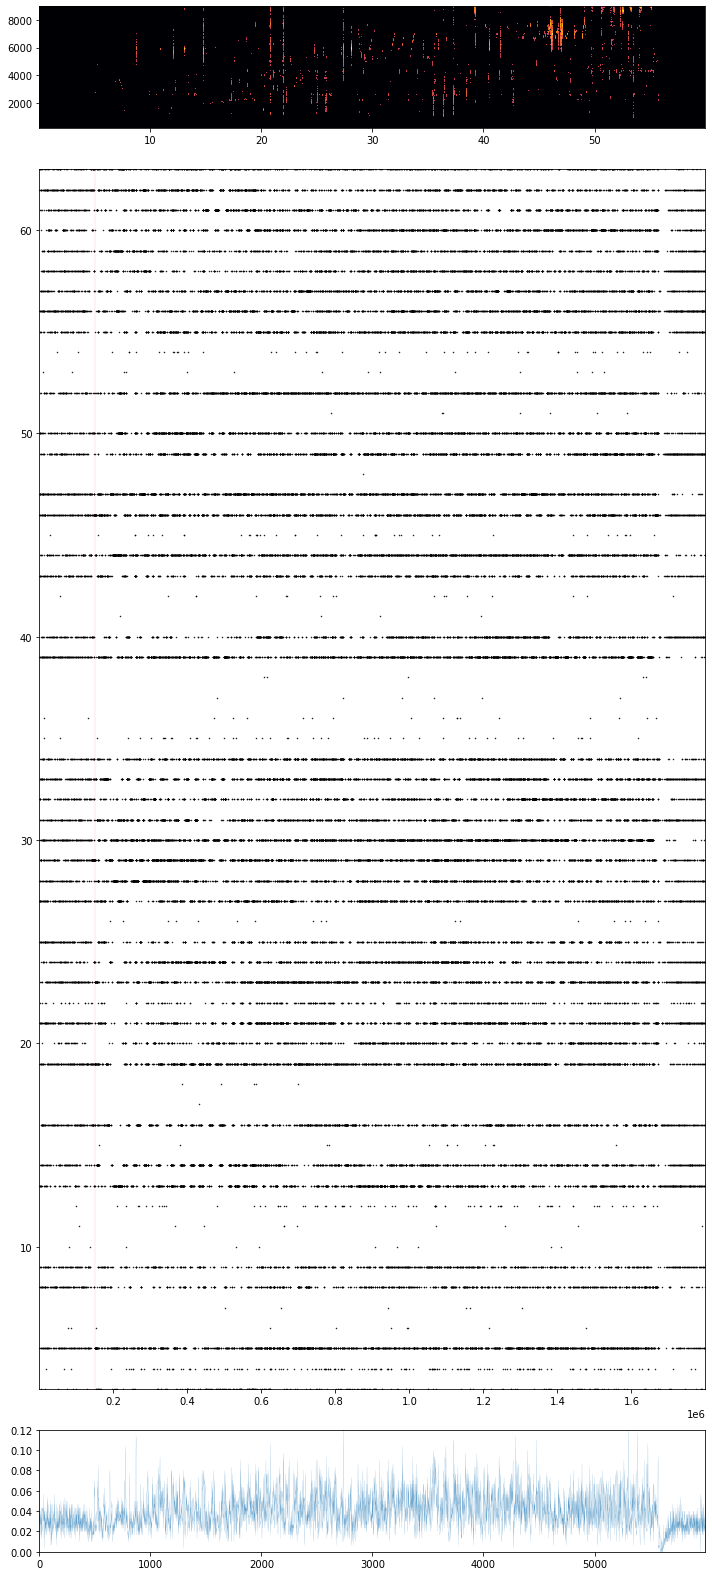

In [81]:
## compute the spectrogram of the sound segment returned by collect_bout
f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), bout_dict['s_f'])

# make a psth
bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  bout_dict['s_f_ap_0'])
#make the psth
psth = np.nansum(coarse(spk_arr, bin_size_sample), axis=0)

# prepare the plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

# plot the spectrogram
ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

# plot the raster
plot_as_raster(spk_arr, t_0=int(-t_pre*bout_dict['s_f_ap_0']), ax=ax[1])

#plot the psth
ax[2].plot(psth);

plt.tight_layout()

### Example: collect all bouts for all clusters and make a dataframe

In [60]:
# select clusters list
clu_list = clu_list_ra_good

spk_arr_list = []
mic_arr_list = []
clu_id_arr_list = []

t_pre = -5 # window starts some time previous to detected bout onset (seconds)
t_post = 5 # window ends soometime posterior to detected bout offset (seconds)

## get the bouts arrays into a bout_dict
for bout_idx, start in enumerate(bout_dict['start_ms']):
    spk_arr, mic_arr = collect_bout(bout_dict, bout_idx, t_pre, t_post, spk_df, clu_list, mic_stream)
    spk_arr_list.append(spk_arr.astype(np.short))
    mic_arr_list.append(mic_arr.astype(np.int16))
    clu_id_arr_list.append(np.array(clu_list))
    
bout_dict['t_pre_ms'] = t_pre * 1000
bout_dict['t_post_ms'] = t_post * 1000

bout_dict['spk_arr'] = spk_arr_list
bout_dict['mic_arr'] = mic_arr_list
bout_dict['clu_id_arr'] = clu_id_arr_list

<ipython-input-48-cb514117b64c>:5: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [62]:
# if you must make into a pandas dataframe
keys_to_df = ['start_sample_nidq', 'start_sample_ap_0', 'len_ms', 'spk_arr', 'mic_arr', 'clu_id_arr']

bout_dict_df = {k: bout_dict[k] for k in keys_to_df}
bout_df = pd.DataFrame.from_dict(bout_dict_df)

bout_df.head()

,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,clu_id_arr
0,157509764,189017379,50765,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-42, -50, -63, -34, -59, -54, -37, -52, -39, ...","[36, 48, 64, 65, 80, 85, 91, 107, 108, 110, 11..."
1,177560061,213078440,38435,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-36, -35, -41, -41, -49, -42, -47, -41, -52, ...","[36, 48, 64, 65, 80, 85, 91, 107, 108, 110, 11..."
2,179512908,215421889,31900,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[31, 43, 43, 29, 28, 14, 44, 47, 33, 30, 28, 2...","[36, 48, 64, 65, 80, 85, 91, 107, 108, 110, 11..."
3,181131886,217364725,44620,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[42, 44, 20, 21, -54, -56, -12, 3, -3, -44, -7...","[36, 48, 64, 65, 80, 85, 91, 107, 108, 110, 11..."
4,191537492,229851811,55725,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[20, 27, 24, 19, 31, 35, 51, 40, 42, 24, 39, 2...","[36, 48, 64, 65, 80, 85, 91, 107, 108, 110, 11..."


### Saving it will break hell loose, because it's too big for a pickle

In [ ]:
# bout_dict_path = os.path.join(exp_struct['folders']['sort'], 'bout_dict_ra_good.pkl')
# logger.info('saving the bout dict to {}'.format(bout_dict_path))
# with open(bout_dict_path, 'wb') as f:
#     pickle.dump(bout_dict, f)
# logger.info('saved')

2021-10-22 11:56:20,020 root         INFO     saving the bout dict to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/sort_0/bout_dict_ra_good.pkl


In [ ]:
# sort_folder = exp_struct['folders']['sort']

# os.makedirs(os.path.join(, exist_ok=True)

# clu_df_path = os.path.join(sort_folder, 'clu_df.pkl')
# clu_df.to_pickle(clu_df_path)

# spk_df_path = os.path.join(sort_folder, 'spk_df.pkl')
# spk_df.to_pickle(spk_df_path)

# mot_dict_path = os.path.join(sort_folder, 'bout_dict_all_ra.pkl')
# with open(mot_dict_path, 'wb') as handle:
#     pickle.dump(bout_dict, handle)

# logger.info('saved sort files to {}'.format(sort_folder)

In [50]:
# bout_df_path = os.path.join(exp_struct['folders']['sort'], 'bout_df_allunits.pkl')
# logger.info('saving the bout dataframe to {}'.format(bout_df_path).format(bout_df_path))
# bout_df.to_pickle(bout_df_path)
# logger.info('saved')

2021-10-06 23:06:23,876 root         INFO     saving the bout dataframe to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/bout_df_allunits.pkl
2021-10-07 00:04:15,786 root         INFO     saved
